<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 11.2: Residual Networks**

This notebook adapts the networks for MNIST1D to use residual connections.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [99]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

12821.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [100]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [101]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [102]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [103]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

# The order of operations within each block should similar to figure 11.5b
# ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# Replace this function
  def forward(self, x):
      # 4 layers -> 32.9% performance on test set
      f = self.linear1(x)
      res1 = f + self.linear2(f.relu())
      res2 = res1 + self.linear3(res1.relu())
      return self.linear4(res2)

  def myforward(self, x):
    h1 = self.linear1(x)
    h2 = self.linear2(h1.relu())
    h3 = self.linear3(h2.relu())

    return self.linear4(h1 + h2 + h3)
  
  def prince_forward(self, x):
    print_variance("Input",x)
    f = self.linear1(x)
    print_variance("First preactivation",f)
    res1 = f+ self.linear2(f.relu())
    print_variance("After first residual connection",res1)
    res2 = res1 + self.linear3(res1.relu())
    print_variance("After second residual connection",res2)
    res3 = res2 + self.linear4(res2.relu())
    print_variance("After third residual connection",res3)
    res4 = res3 + self.linear5(res3.relu())
    print_variance("After fourth residual connection",res4)
    res5 = res4 + self.linear6(res4.relu())
    print_variance("After fifth residual connection",res5)
    return self.linear7(res5)
  
  def gemini2_forward(self, x):
    h1 = self.linear1(x)
    h1 = h1.relu()

    h2 = self.linear2(h1)
    h2 = h2.relu()

    h3 = self.linear3(h2)
    h3 = h3.relu()

    return self.linear4(h1 + h2 + h3)
  
  def suggestedGeminiForward(self, x):
    h1 = self.linear1(x) + x
    h1 = h1.relu()

    h2 = self.linear2(h1) + h1
    h2 = h2.relu()

    h3 = self.linear3(h2) + h2
    h3 = h3.relu()

    return self.linear4(h3)


In [104]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [107]:
#Define the model
model = ResidualNetwork(40, 10)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initialized MLPBase model with 25310 parameters
tensor([[-0.3320, -0.4719, -0.7787,  ..., -0.7167, -0.9620, -0.8902],
        [ 1.9655,  2.3002,  2.2134,  ..., -1.6875, -1.4264, -1.3642],
        [-0.0193,  0.0786,  0.6249,  ..., -1.0856, -1.7981, -2.3153],
        ...,
        [-1.6945, -1.2806, -0.6513,  ..., -0.7237, -0.3827, -0.0317],
        [ 0.9965,  0.8084,  0.1553,  ..., -0.3029, -0.2856, -0.1184],
        [-0.6940, -0.2753,  0.2927,  ..., -1.2162, -1.4649, -1.6510]])
tensor([2, 6, 4,  ..., 5, 4, 8])
torch.Size([4000])
torch.Size([4000, 40])
torch.Size([1000, 40])
tensor([[-0.0788, -0.2107, -0.0918,  ...,  1.1342,  0.8463,  0.3461],
        [ 0.4710,  0.7311,  0.7837,  ..., -0.4625, -0.1845,  0.0968],
        [ 1.7739,  1.2690,  1.3767,  ..., -0.7002, -0.1029,  0.0740],
        ...,
        [-0.6092, -0.1108,  0.2681,  ..., -0.0785, -0.1429,  0.0278],
        [-0.9666, -0.0356,  0.5749,  ..., -1.2560, -2.1293, -2.7991],
        [-0.5193, -0.6987, -1.2810,  ...,  0.6599,  0.877

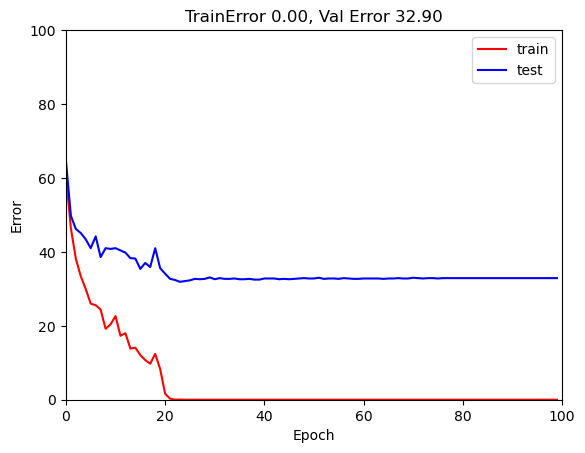

In [106]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()

The primary motivation of residual networks is to allow training of much deeper networks.   

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?